# COVID-19 OxCGRT Viewer
This notebook is intended to quickly visualize time-series COVID-19 policy decisions made by a country of interest.

For more details on the underlying dataset, see: https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker#data

## Configuration
Loading in dependencies and any other requirements

In [1]:
# Load dependencies
import requests, io, json, urllib
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Select country of interest (using ISO 3166-1 alpha-3 country code)
country_iso3 = "MEX"

## Access data API

In [3]:
# Get date range 
date_start = "2020-02-01" # date to start tracking (will go until today)
date_list = pd.date_range(start=date_start, end=datetime.today()).tolist()
date_strs = [date.strftime("%Y-%m-%d") for date in date_list]
n = len(date_strs)

# Arrange urls
urls = [f"https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/actions/{country_iso3}/{date_str}" for date_str in date_strs]

# Submit requests
dfs = [None for _ in range(0,n)]
for i in range(0,n):
    r = urllib.request.urlopen(urls[i])
    data = json.loads(r.read().decode("utf-8"))
    dfs[i] = pd.DataFrame(data['policyActions'])
    dfs[i]["Date"] = date_strs[i]
    
# Collapse into one dataframe
df = pd.concat(dfs, axis=0)

# Add field to store policy code category (e.g. C, E, H)
df["policy_category"] = df["policy_type_code"].str[0]

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Preview result
df.head(5)

,policy_type_code,policy_type_display,policyvalue,policyvalue_actual,flagged,is_general,notes,flag_value_display_field,policy_value_display_field,Date,policy_category
0,C1,School closing,0,0.0,None,None,None,General,No measures,2020-02-01,C
1,C2,Workplace closing,0,0.0,None,None,None,General,No measures,2020-02-01,C
2,C3,Cancel public events,0,0.0,None,None,None,General,No Measures,2020-02-01,C
3,C4,Restrictions on gatherings,0,0.0,None,None,None,General,No restrictions,2020-02-01,C
4,C5,Close public transport,0,0.0,None,None,None,General,No Measures,2020-02-01,C


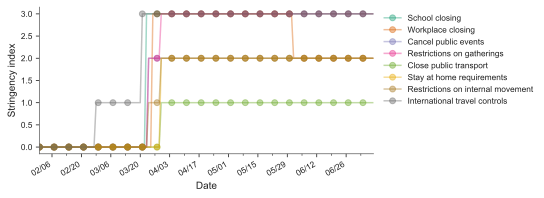

In [14]:
# Select category to plot
desired_category = "C"

# Reduce subset to desired category
df_subset = df[df["policy_category"] == desired_category]

# Get unique policy types per category
policy_codes = df_subset["policy_type_code"].unique()
policy_types = df_subset["policy_type_display"].unique()
policy_dict = {policy_code : policy_type for policy_code, policy_type in zip(policy_codes,policy_types)}

# Create time-series plot for catgory
fig, ax = plt.subplots(figsize=(6,3))
for policy_code in policy_codes:
    df_subsubset = df_subset[df_subset["policy_type_code"] == policy_code]
    df_subsubset.plot(x="Date",y="policyvalue_actual",ax=ax,label=policy_dict[policy_code],marker='o',markevery=7,alpha=0.4)
plt.legend(fontsize="small", bbox_to_anchor=(1.01, 1.0))
plt.ylabel("Stringency index")
date_form = mdates.DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
fig.autofmt_xdate()
plt.show()